<a href="https://colab.research.google.com/github/DeisyZermeno/desihigh/blob/main/Espanol/DESI_es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sparclclient

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.8/113.8 kB 3.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cambia a la carpeta específica
%cd /content/drive/MyDrive/ColabNotebooks/DESI/desihigh


/content/drive/MyDrive/ColabNotebooks/DESI/desihigh


In [ ]:
# Aquí cargamos un montón de librerías útiles, nada de preocuparse. Lo usaremos más tarde.
# Es común añadir la mayoría al inicio, es más claro.
# Para recolectar los archivos.
import glob

# Para hacer gráficos.
import pylab as pl

# ¿Recuerdas Excel? Quizá no. Esta es la versión de "Silicon Valley".
import pandas as pd

#No harás ciencia sin esta librería.
import numpy as np

# Más gráficos.
from matplotlib import pyplot as plt

# Hablaremos de esto más tarde.
from scipy import stats

# Un par de cosas útiles para trabajar con datos en astronomía.
from astropy.table import Table, join, vstack

#Si sabes la posición de una galaxia de DESI, ¡hagamos una foto de ella!
from tools.legacy import cutout

from sparcl.client import SparclClient

# *Instrumento espectroscópico de energía oscura*

Hoy, continuamos el legado de [Slipher](https://es.wikipedia.org/wiki/Vesto_Slipher), [Hubble](https://es.wikipedia.org/wiki/Edwin_Hubble), [Vera Rubin](https://es.wikipedia.org/wiki/Vera_Rubin) y otros con el estudio DESI de *30 millones* de galaxias. ¡Eso es mucho más que las 24 originales de Hubble!

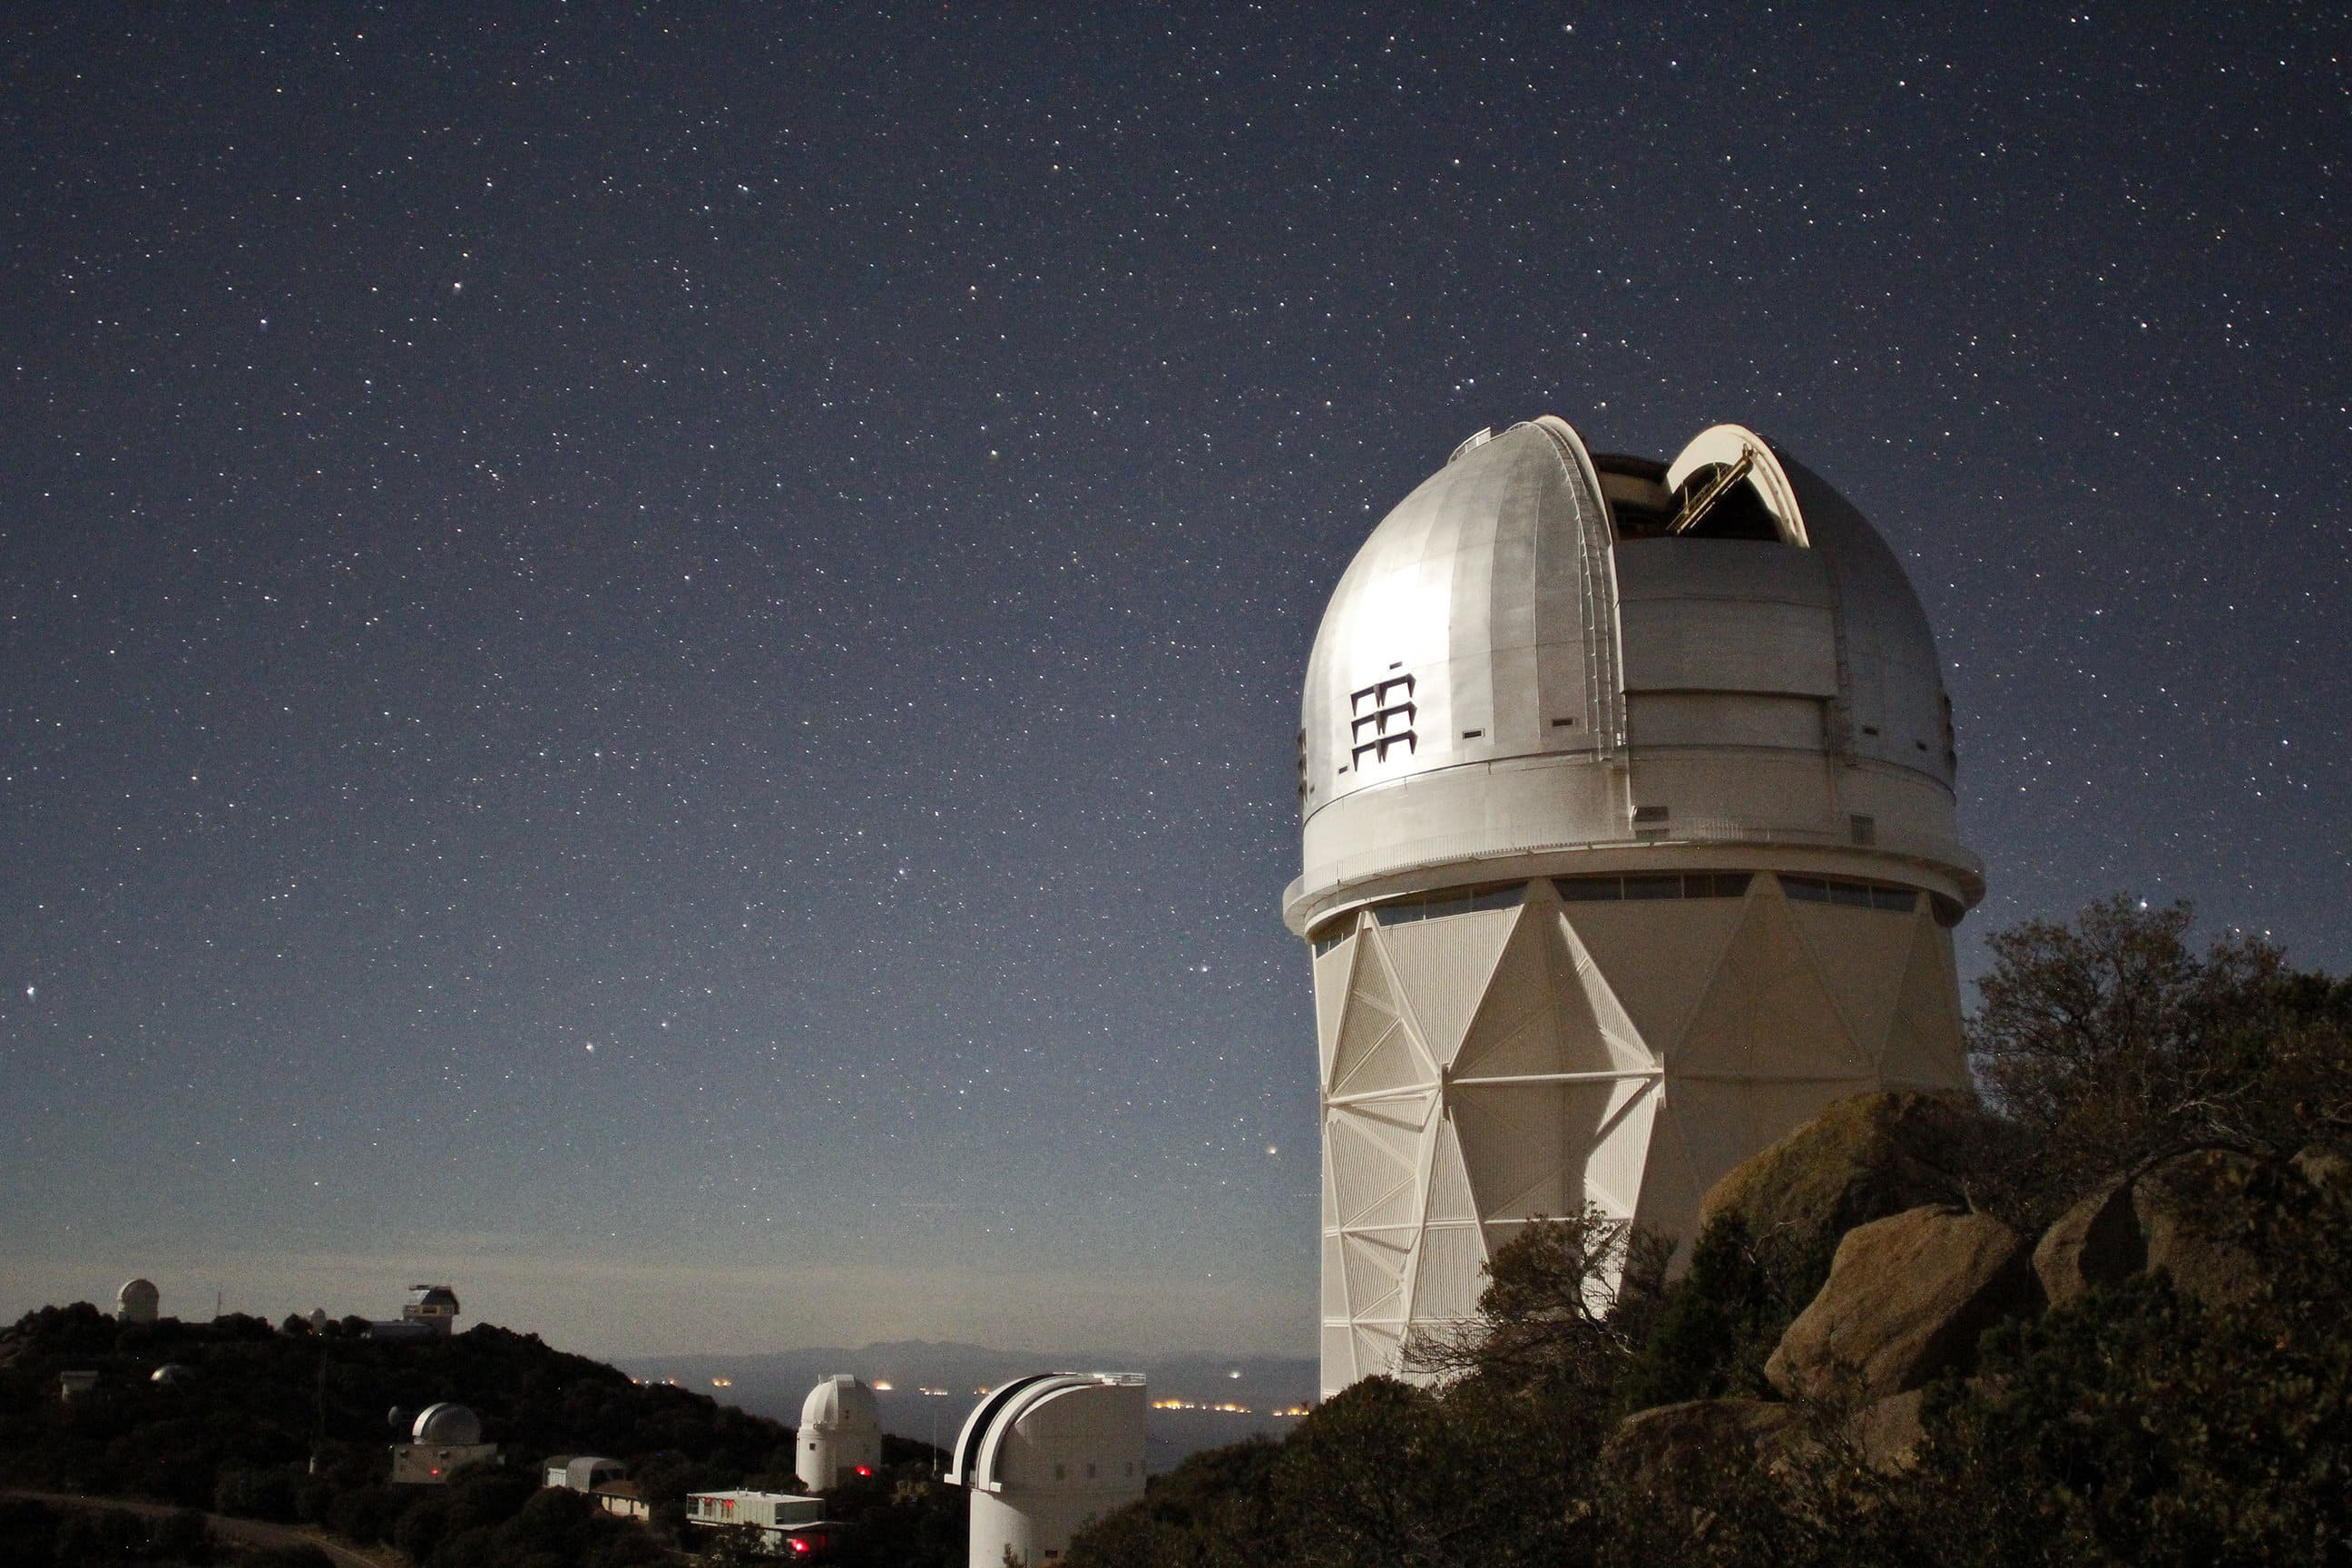

Para obtener tantas, necesitamos un telescopio lo suficientemente grande para observar galaxias muy débiles. Con un espejo de 4 m de diámetro, el telescopio Mayall en Kitt Peak es perfecto:

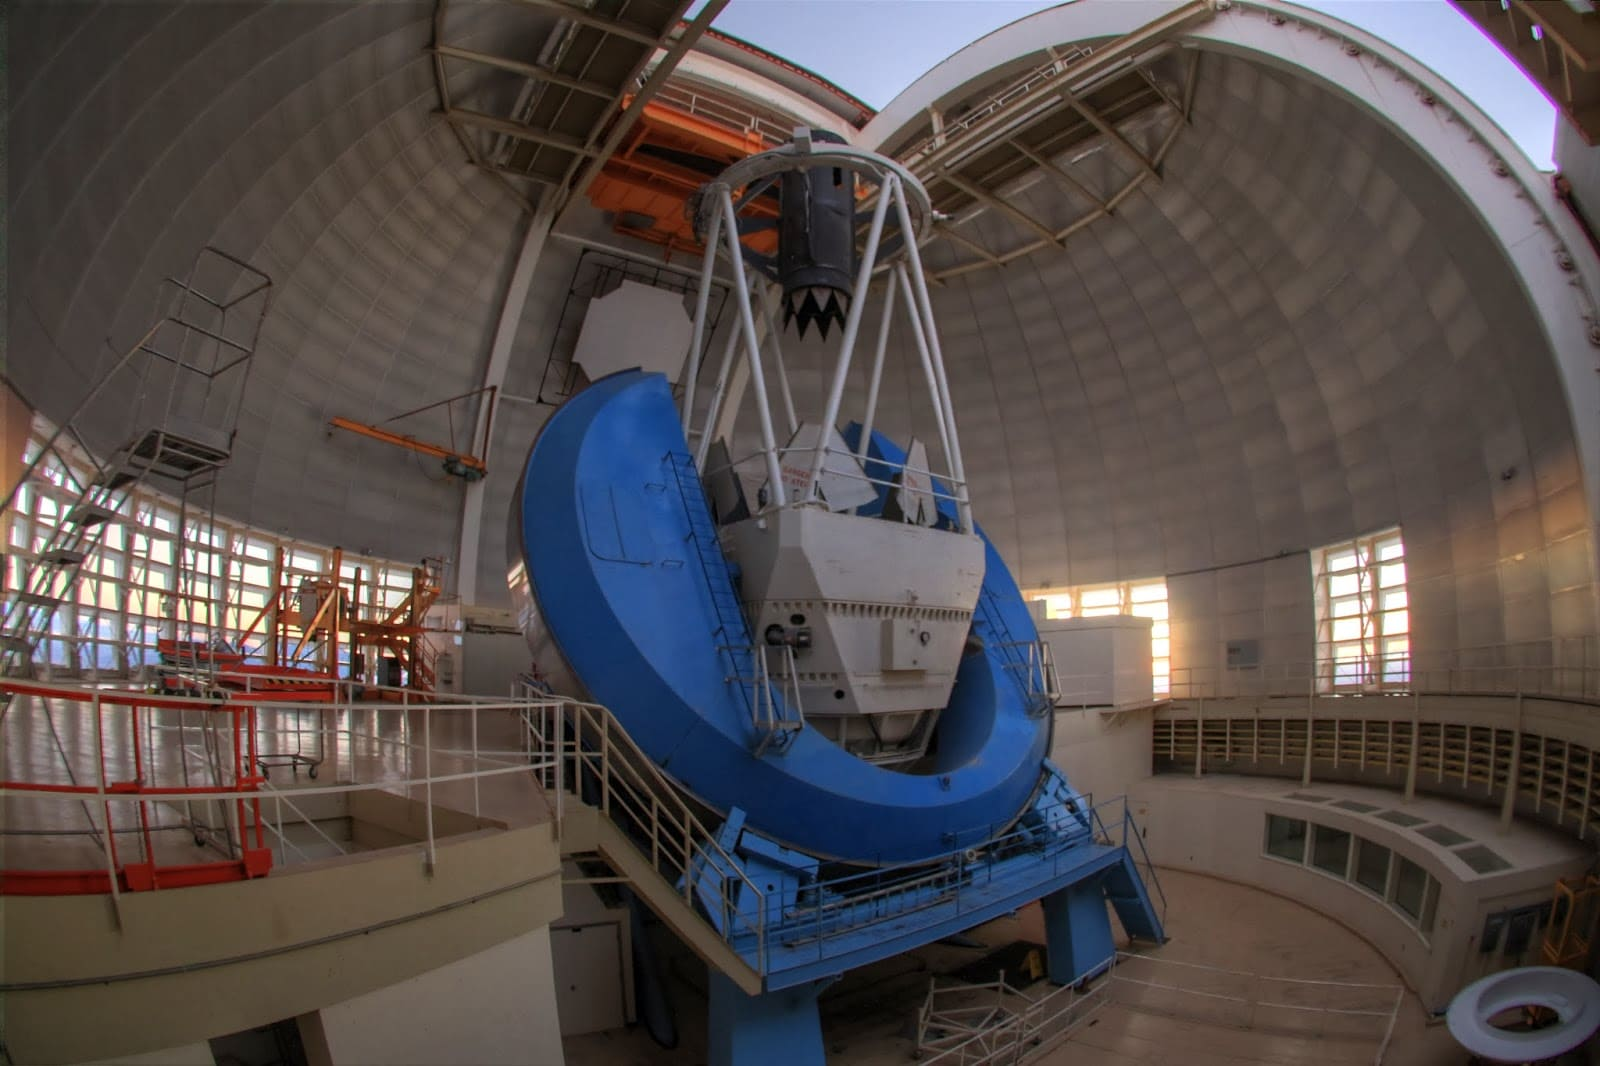

Cómo hizo Hubble una vez, también necesitamos observadores que manejen el telescopio por nosotros. Dentro de DESI, todo el mundo tiene su turno en esto (¡seas un experto o no!). Aquí está [Satya](https://satyagontcho.space/) en la sala de control mostrándonos cómo

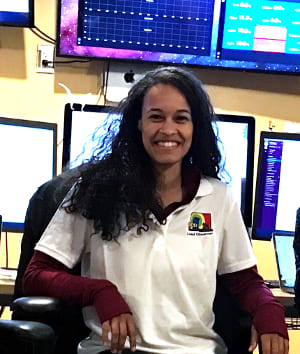

Escuchemos primero a Satya que nos cuenta sobre su experiencia en la montaña Kitt Peak, en Arizona:

*Normalmente, la noche comienza unas horas antes de la puesta de sol. Los observadores suben al telescopio y se reunen con un grupo de colaboradores de DESI para decidir el plan de observación de la noche. De hecho, en función del clima y de lo avanzados que estemos en la observación de todas las galaxias y cuásares de nuestra lista, debemos decidir qué debemos observar prioritariamente esa noche. Una vez hecho el plan, todos salimos del telescopio para cenar, contemplar una última y hermosa vista antes de la puesta de sol desde la cima de la montaña, y volver al telescopio para empezar nuestro trabajo. Mientras se pone el sol, hacemos pruebas para asegurarnos de que el telescopio está bien montado. Justo cuando el cielo se oscurece lo suficiente, abrimos la cúpula y empezamos a trabajar.*

*Durante la noche, el papel de un observador es monitorear la eficacia del instrumento que recolecta la luz de las galaxias y cuásares lejanos, vigilar el clima y, en consecuencia, utilizar su criterio para adaptar el plan de la noche. En la imagen de abajo se puede ver una pequeña muestra de lo que se ve en las pantallas y que hay que vigilar para asegurarse de que todo funciona como debe. Esto continúa hasta que sale el sol a la mañana siguiente. Observar es una actividad extremadamente gratificante porque nos da la oportunidad de conocer todos los pasos y la magnitud del trabajo que se necesita para obtener datos de calidad. Imagínese esto: estamos moviendo suavemente un telescopio que pesa varias toneladas, ajustando la posición de fibras ópticas del grosor de 1/3 de un cabello para que apunten exactamente a una galaxia o a un cuásar con el fin de recoger sus fotones que viajaron miles de millones de años luz para llegar a nosotros. A veces, al trabajar con catálogos de datos durante mucho tiempo, olvidamos lo increíblemente privilegiado y especial que es nuestro trabajo. Conseguimos construir grandes instrumentos de última generación que recogen los diminutos y escasos fotones de objetos celestes lejanos que, a su vez, utilizaremos para jugar a los detectives con el fin de reconstruir la historia de nuestro universo. Qué cool.*

¡Este puedes ser tú algún día!

Desde el telescopio, nuestros datos parecen bastante irreconocibles:

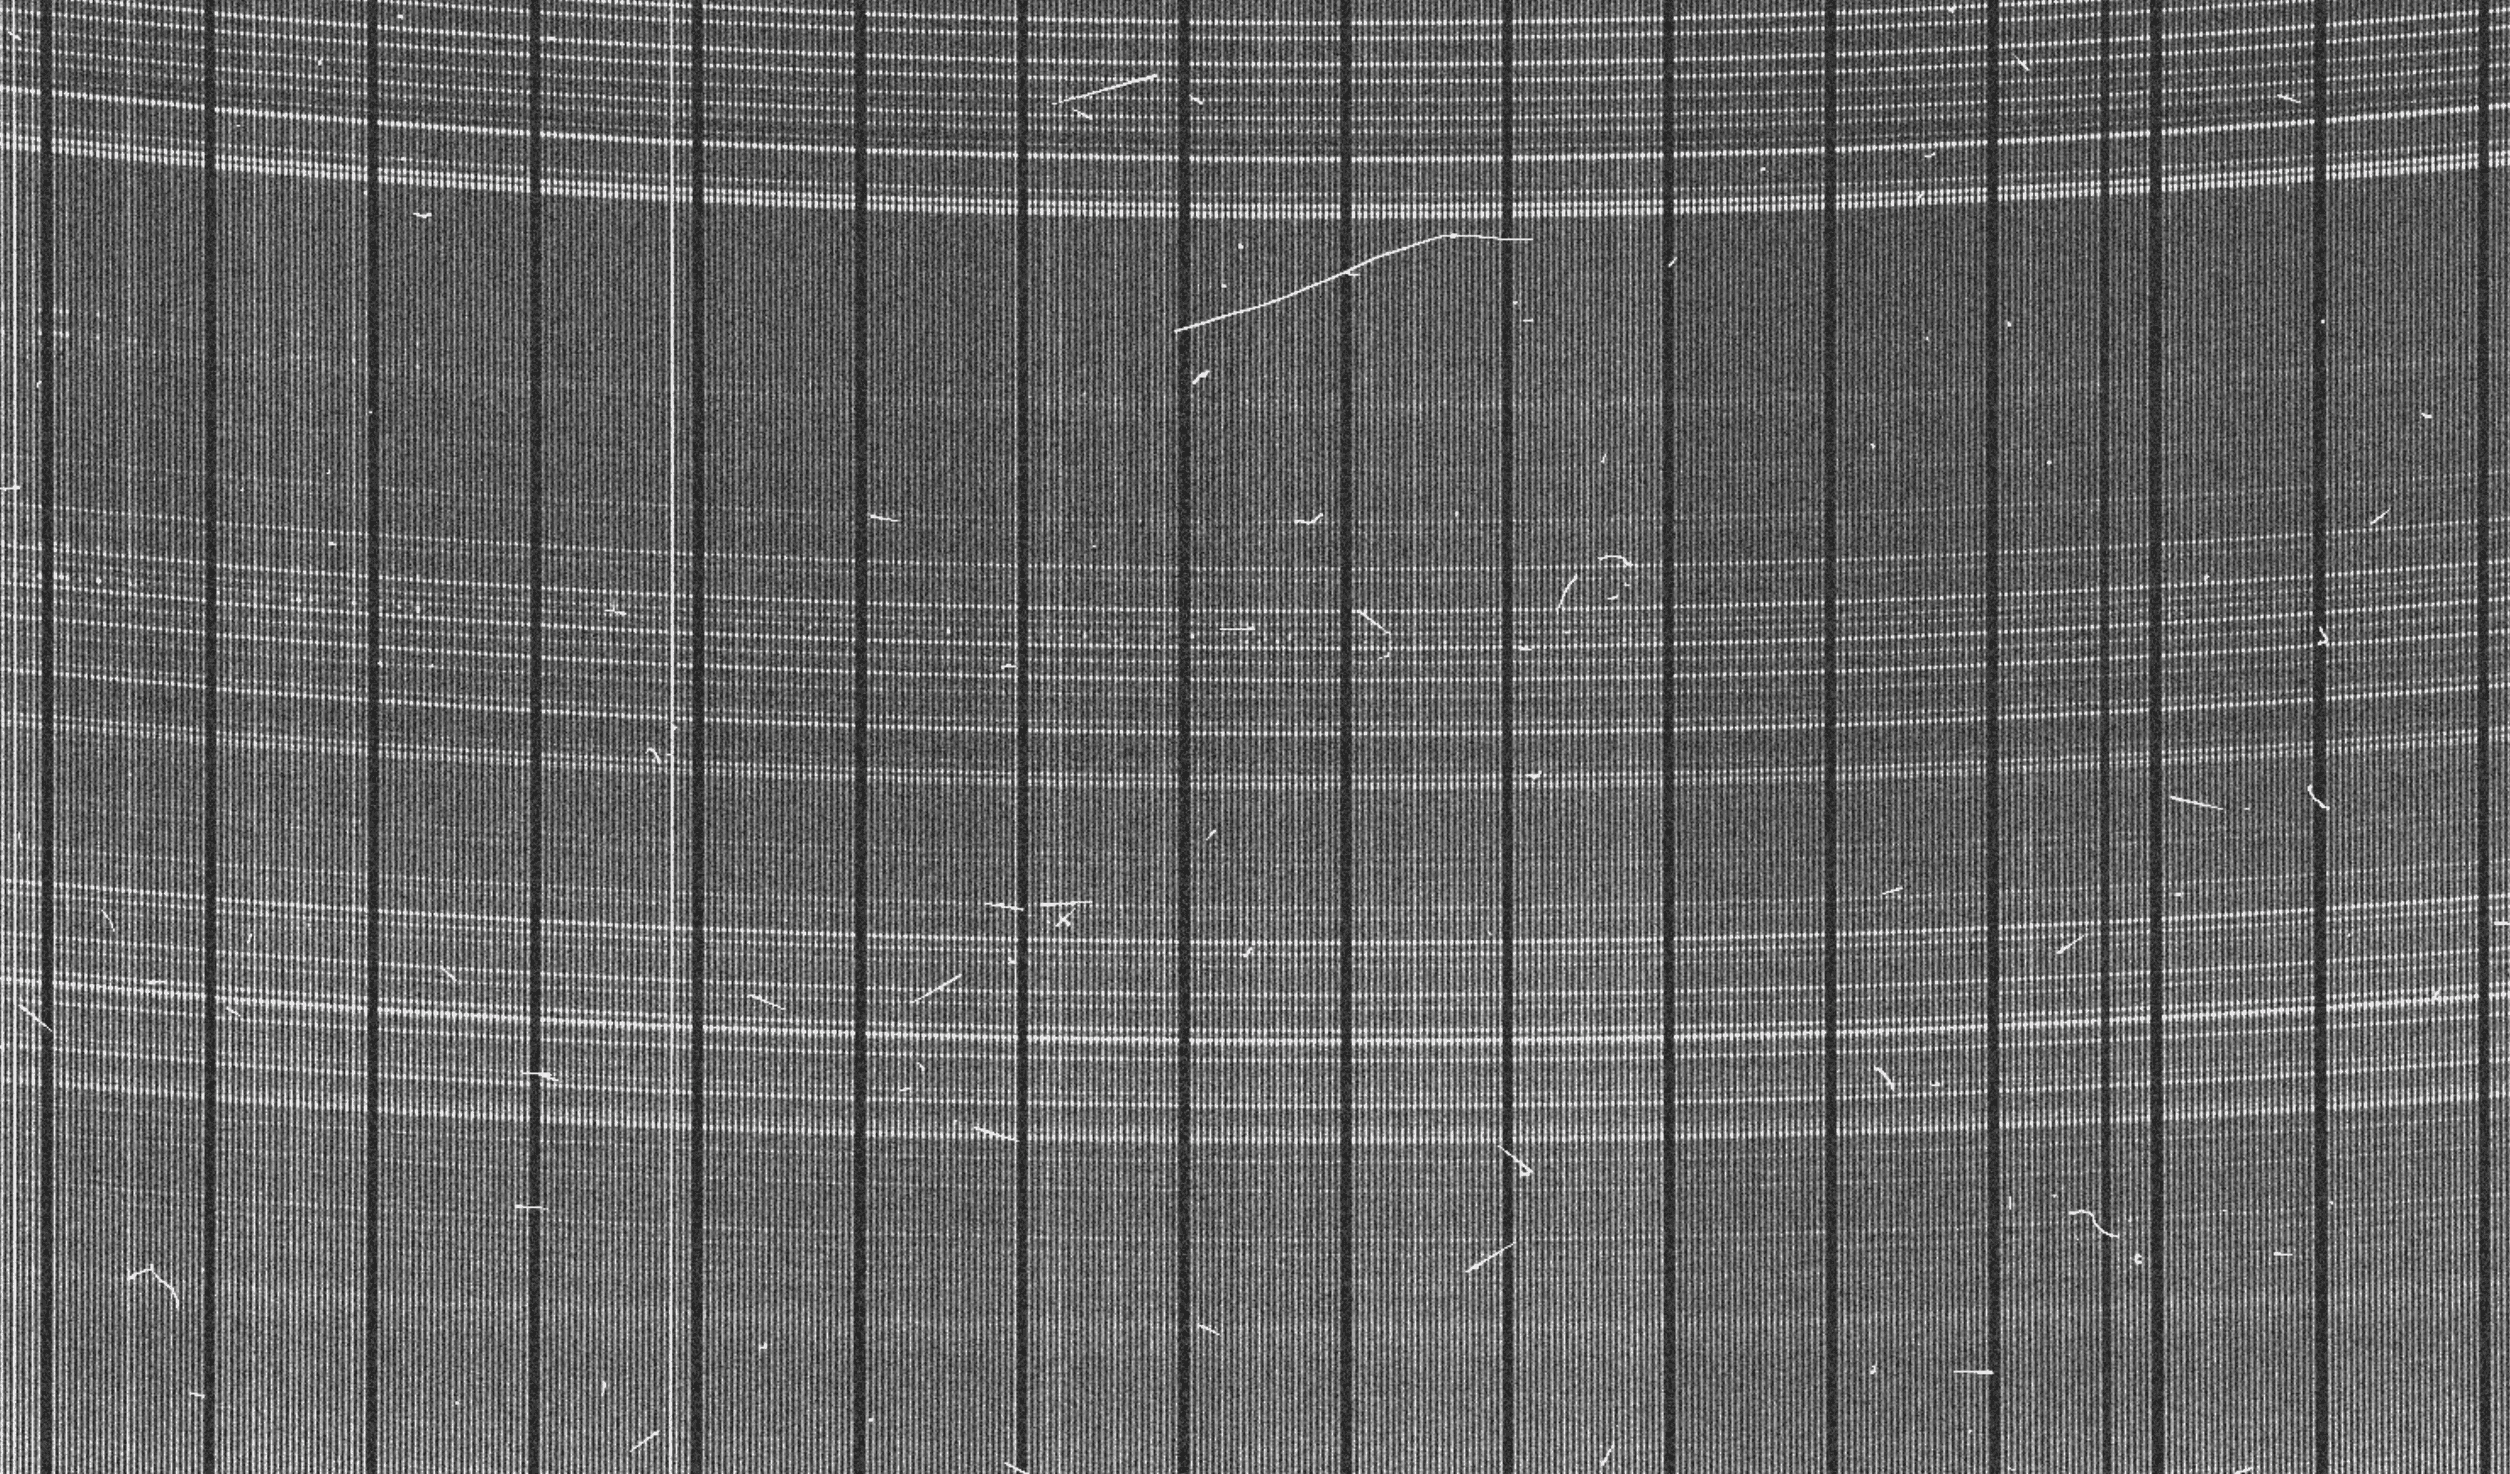

Aquí estás viendo la luz de 500 fibras ópticas (cada una recolectando la luz de una galaxia) empaquetadas en una cámara CCD. Los arcos horizontales corresponden a una longitud de onda dada, y los arcos brillantes corresponden a líneas brillantes del cielo, ¡una completa molestia!

Los trazos aparentemente aleatorios son rayos cósmicos, detecciones de partículas de alta energía generadas dentro de la atmósfera.

Necesitamos calibrar y limpiar cuidadosamente estas imágenes para recuperar la luz de la galaxia que realmente nos importa. Supongamos que algunas personas inteligentes ya han hecho esto por nosotros, y han mirado las imágenes limpias de la luz de algunas galaxias con DESI.

También buscaremos agregar algunos marcadores que indiquen las líneas fuertes del hidrógeno (que aprendimos anteriormente) en algunos espectros de cuásares de DESI.

A continuación utilizaremos algunas funciones interesantes que si quieres conocer un poco mas de lo que significan y de donde vienen te invito a revisar el cuadernillo [Intro_es.ipynb](https://github.com/DESIHIGH/desihigh/blob/main/Espanol/Intro_es.ipynb)


In [ ]:
def Rydberg(n, m):
    # Longitud de onda en el vacío del Hidrógeno [nanometros].
    result = 1.096e-2 * (1. / n / n - 1. / m / m)
    return 1. / result

In [ ]:
# Línea de Lyman-alfa del Hidrógeno.
Lya        = 10. * Rydberg(1, 2)

# La serie de Balmer del Hidrógeno.
Balmers    = 10. * np.array([Rydberg(2, m) for m in np.arange(6, 3, -1)])
df = pd.DataFrame(Balmers.reshape(1,3))
df.columns=['n = 6', 'n = 5', 'n = 4']
# Veamos nuestro resultado
df

,n = 6,n = 5,n = 4
0,4105.839416,4344.803615,4866.180049


Ahora vamos a seleccionar un tipo de galaxia que se observa con DESI (pensamos en las galaxias como diferentes _trazadores_ de materia oscura). Comenzaremos con los cuásares (QSO), que se explicarán más adelante. Al final del cuaderno, tendrás la oportunidad de seleccionar otros tipos de galaxia.

Para tu deleite visual, tienes cualquiera de las siguientes

- MWS: El censo de la Vía Láctea (The Milky Way Survey), un subconjunto de objetivos que intentan atrapar estrellas y [enanas blancas](https://es.wikipedia.org/wiki/Enana_blanca).
- BGS: El censo de galaxias brillantes (The Bright Galaxy Survey), algunas de las galaxias más brillantes y bonitas del censo DESI.
- LRG: El censo de galaxias rojas (Luminous Red Galaxy), muy rojo, muy luminoso (¡los astrónomos no suelen ser tan creativos!). [Aproximadamente 6 mil millones de años de edad y del orden de $10^{11}$ masas solares.](https://academic.oup.com/mnras/article/377/2/787/1038423).
- ELG: Galaxias de líneas de emisión (Emission line galaxy), con su propio cuaderno: [DesigningDESI_es.ipynb](https://github.com/michaelJwilson/desihigh/blob/main/Espanol/DesigningDESI_es.ipynb).

Ok, primero necesitamos cargar los datos que necesitamos. Los paquetes anteriores son muy útiles para esto. Ponlo a prueba, rompelo
y mira lo que hay ahí!

In [ ]:
# Necesitamos generar un "cliente" para poder interactuar con los servicios de SPARCL
# Una vez hecho esto podremos acceder a datos y realizar operaciones con ellos!!
client = SparclClient()

Accederemos a la información de nuestros espectros con sus TARGETID. Recuerda que existe un gran catálogo de diferentes espectros y diferentes trazadores, si quieres conocer como obtener los TARGETID de otro tipo de trazador puedes acceder al cuadernillo de **Accessing Data** que explica a fondo como estan estructurados los datos.

Por el momento analicemos como trazadores a los QSO mencionados anteriormente, de los cuales a continuación declaramos sus TARGETID y la información que requerimos de éstos para el análisis que haremos.

In [ ]:
TRGETID=[39627847626654815, 39633329401630516,39633329405821412,39633158395660371,39633329405823023]
inf = ['wavelength', 'flux', 'redshift','targetid', 'spectype', 'ra', 'dec']
spectra = client.retrieve_by_specid(TRGETID,
    include = inf)
spec = spectra.records

In [ ]:
df = pd.DataFrame(spec)

In [ ]:
ngal = len(TRGETID)

In [ ]:
flux_ = df.iloc[:5,df.columns.get_loc('flux')]
wave_l =  df.iloc[:5,df.columns.get_loc('wavelength')]

Text(0.5, 0.91, "['QSO'] Trazadores")

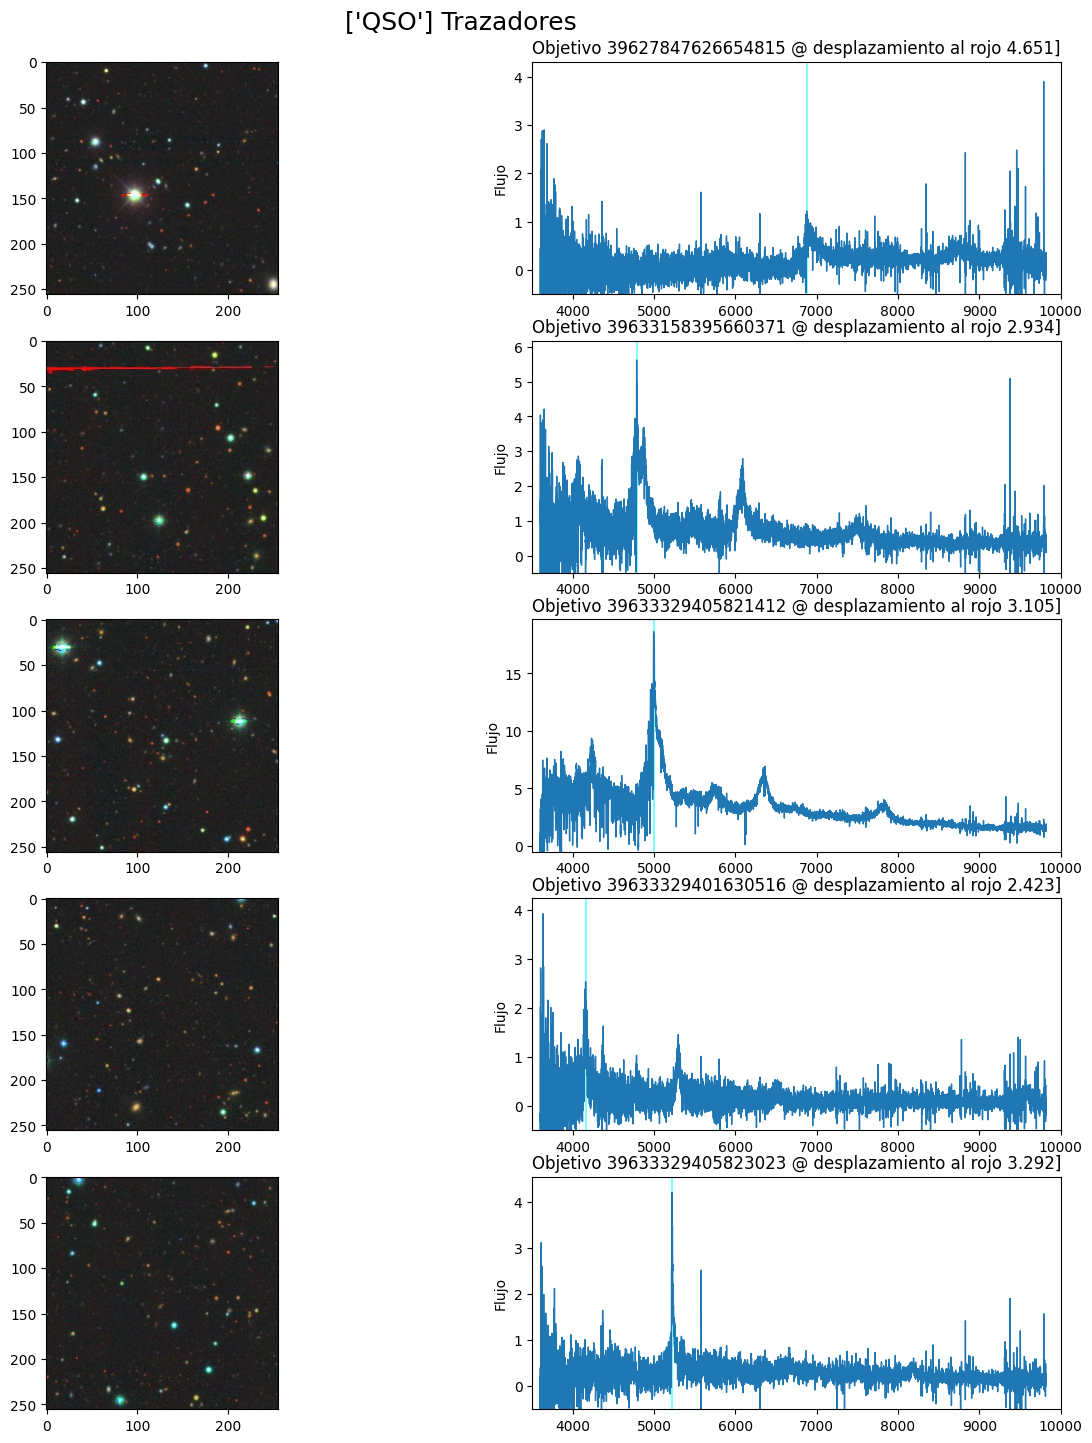

In [ ]:
# Hace la distribución de los gráficos.
fig, axes  = plt.subplots(ngal, 2, figsize=(15., 3.5 * ngal))

for i, tid in enumerate(df['targetid'][:ngal]):
  redshift = df['redshift'][i]

  # Añade una línea vertical. Aquí para mostrar la linea de Lyman-alfa.
  axes[i,1].axvline((1. + redshift) * Lya, c='cyan', alpha=0.5)

  # Añade las líneas de Balmer.
  for balmer in Balmers:
    axes[i,1].axvline((1. + redshift) * balmer, c='magenta', alpha=0.5)

  # ¡Finalmente, grafica el espectro de la galaxia!
  axes[i,1].plot(wave_l[i], flux_[i], lw=1)

  # Añade un título.
  axes[i,1].set_title(f'Objetivo {tid} @ desplazamiento al rojo {redshift:.3f}]')

  # Define los límites de los ejes.
  axes[i,1].set_xlim(3.5e3, 1.e4)
  axes[i,1].set_ylim(bottom=-0.5)

  axes[i,1].set_ylabel('Flujo')

  # Añade una foto de cada galaxia.
  url = cutout(axes[i,0], df['ra'][i], df['dec'][i])

fig.suptitle(f'{tracers} Trazadores', fontsize=18, y=0.91)

Observa cómo las líneas de hidrógeno que vemos son muy amplias. Esto se debe a que el Hidrógeno se está moviendo rápidamente dentro de este tipo de galaxia, conocida como Cuásar (Quasar) u "Objeto cuasi-estelar". Están muy distantes, sin embargo son muy brillantes, debido a que la materia se acumula en un gran agujero negro en su centro. Consulta [aquí](https://es.wikipedia.org/wiki/Cuásar) para obtener más detalles.

Ahora es tu turno, prueba a cambiar tracers = ['qso'] a tracers = ['lrg'] en la celda [9] de arriba y vuelve a ejecutar las celdas de arriba para rehacer estos gráficos para un tipo diferente de galaxia. Recuerda, necesitas presionar shift-return para evaluar una celda. ¿Qué notas que es diferente entre las diferentes galaxias trazadoras y sus colores?

Ahora que eres un experto, ¿puedes averiguar qué líneas además del hidrógeno están presentes aquí (y trazarlas)?
Puedes probar la lista [aquí](http://classic.sdss.org/dr6/algorithms/linestable.html) para comenzar.